<a href="https://colab.research.google.com/github/leonardevop/mvp_2/blob/main/MVP_2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Sprint II - Deep Learning: Visão Computacional

Leonard Ravaglia Pereira

MVP

# Objetivo

O objetivo deste trabalho é disponibilizar um modelo de crie imagens de animes baseado em modelos Keras.

In [21]:
pip install tensorflow

## Carregando bibliotecas, dataset e preparando dados

In [33]:
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for assembling a Neural Network model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Dropout # adding layers to the Neural Network model
from tensorflow.keras.utils import plot_model # for plotting model diagram
from tensorflow.keras.optimizers import Adam # for model optimization

import os
import glob
from PIL import Image
import imageio
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
from IPython import display
import warnings
warnings.filterwarnings("ignore")

#from datasets import load_dataset
!git clone https://github.com/leonardevop/mvp_2.git

#dataset = load_dataset("https://huggingface.co/datasets/keremberke/pokemon-classification/keremberke/pokemon-classification")

Tensorflow/Keras: 2.12.0
fatal: destination path 'mvp_2' already exists and is not an empty directory.


Nessa etapa, são selecionadas e carregadas as imagens para treinamento.

É feito ainda um pré-processmanento, em que as imagens são convertidas para um formato 64x64.

Por fim, teremos uma lista de imagens normalizadas.

In [34]:
def load_images(dataset_dir):
    images = []

    for img in glob.glob(os.path.join(dataset_dir, '*.jpg')):
        image = Image.open(img)
        #redimensionando tamanhos das imagens e normalizando
        image = ((np.array(image.resize((64,64))).astype('float32'))-127.5)/127.5
        images.append(image)
    return images

# Carregando imagens do dataset
repo_dir = "mvp_2"
path = os.path.join(repo_dir, "images")
train_images = load_images(path)
print("Número de imagens carregadas para treino:", len(train_images))

Número de imagens carregadas para treino: 999


Convertendo a lista para uma array numpy.

In [40]:
train_images = np.array(train_images)
print(train_images.shape)

(999, 64, 64, 3)


Consultando conversão de registro de primeira imagem no array Numpy.

In [39]:
train_images[0]

array([[[ 0.9137255 ,  1.        ,  0.9607843 ],
        [ 0.9607843 ,  1.        ,  0.99215686],
        [ 0.99215686,  0.9843137 ,  1.        ],
        ...,
        [-0.827451  , -0.04313726, -0.85882354],
        [-0.8980392 , -0.02745098, -0.92941177],
        [-0.8901961 ,  0.05098039, -0.92156863]],

       [[ 0.88235295,  0.9764706 ,  0.92941177],
        [ 0.9529412 ,  1.        ,  0.9843137 ],
        [ 0.9843137 ,  0.9764706 ,  1.        ],
        ...,
        [-0.9529412 , -0.16078432, -0.96862745],
        [-0.92156863, -0.04313726, -0.9529412 ],
        [-0.88235295,  0.06666667, -0.9137255 ]],

       [[ 0.92156863,  0.9764706 ,  0.94509804],
        [ 0.9764706 ,  1.        ,  0.9843137 ],
        [ 0.9764706 ,  0.9529412 ,  0.9843137 ],
        ...,
        [-1.        , -0.28627452, -1.        ],
        [-0.9764706 , -0.15294118, -0.9843137 ],
        [-0.92941177,  0.00392157, -0.9372549 ]],

       ...,

       [[ 0.94509804,  0.99215686,  0.9372549 ],
        [ 0

Plotando algumas imagens utilizadas.

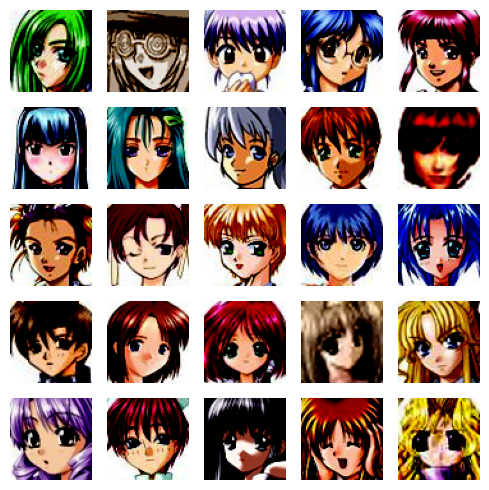

In [43]:
def plot_image_grid(images, grid_shape):
    fig, axes = plt.subplots(grid_shape[0], grid_shape[1], figsize=(5, 5))
    for i, ax in enumerate(axes.flatten()):
        image = images[i]
        ax.imshow(image)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
grid_shape = (5, 5)

# Display the image grid
plot_image_grid(train_images[:grid_shape[0]*grid_shape[1]], grid_shape)

# Criando redes

### Criando rede neural geradora

Definindo uma rede neural geradora (generator network) usando a biblioteca Keras com o TensorFlow para criar uma Rede Generativa Adversarial (GAN) para gerar as imagens.

In [47]:
# Dimensão do vetor de ruído de entrada para a rede geradora
noise_dim = 200

#Definindo arquitetura da rede
def build_generator():
    model = Sequential()

    # Calculando nós da primeira camada oculta
    n_nodes = 8 * 8 * 128

    #Adionando camada densa
    model.add(Dense(n_nodes, input_dim=noise_dim))
    model.add(Reshape((8, 8, 128)))

    # Adicionando camada deconvolucional com função de ativação Relu com dimensão 16 x 16
    model.add(Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same'))
    model.add(ReLU())

    # Adicionando camada deconvolucional com função de ativação Relu com dimensão 32 x 32
    model.add(Conv2DTranspose(filters=256, kernel_size=(4,4), strides=(2,2), padding='same'))
    model.add(ReLU())

    # Adicionando camada deconvolucional com função de ativação Relu com dimensão 64 x 64
    model.add(Conv2DTranspose(filters=512, kernel_size=(4,4), strides=(2,2), padding='same'))
    model.add(ReLU())

    # Camada de Saída com função de ativação em tangente hiperbólica
    model.add(Conv2D(filters=3, kernel_size=(5,5), activation='tanh', padding='same'))
    return model

## Criando rede discriminadora

Combinando com o discriminador em um modelo de GAN para treinar a rede para geração de imagens de rostos de anime realistas a partir do ruído aleatório.

A função abaixo retornará o modelo sequencial da rede discriminadora com todas as camadas definidas.

In [48]:
def build_discriminator():
    #Dimensão de entrada das imagens que alimentarão o discriminador
    in_shape = (64,64,3)
    #Criando modelo sequencial
    model = Sequential()

    # Adicionando camada convolucional com 64 filtros
    model.add(Conv2D(filters=64, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    # Adicionando camada convolucional com 128 filtros
    model.add(Conv2D(filters=128, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    # Adiciona uma camada de achatamento (flatten) para transformar a saída da última camada convolucional em um vetor unidimensional
    model.add(Flatten())
    # Adicionando camada de dropout para evitar overfitting
    model.add(Dropout(0.3))
    # Adiciona uma camada densa com um único neurônio na saída, com função de ativação sigmoid.
    model.add(Dense(1, activation='sigmoid')) # Output Layer
    return model

Agora, cria-se um objeto para cada modelo de rede neural geradora e discriminadora

In [49]:
#Criando objeto gerador e discriminador
generator = build_generator()
discriminator = build_discriminator()

Criando uma imagem com gerador não treinado.

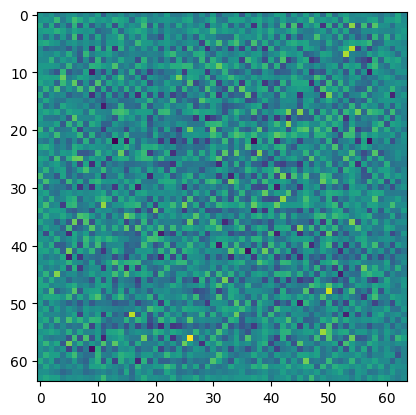

In [50]:
noise = tf.random.normal([1,200])
fake_image = generator(noise, training=False)

plt.imshow(fake_image[0, :, :, 0])

## Definindo funções de perda e otimizadores

Definindo funções de perda e otimizadores.
As funções de perda irão guiar o gerador e o discriminador a melhorarem seus desempenhos durante o processo de adversarialidade.

In [57]:
# Otimizador que será utilizado para atualizar os pesos do gerador durante o treinamento da GAN.
gen_optim =  Adam(learning_rate=0.0002, beta_1=0.5)

# Otimizador que será utilizado para atualizar os pesos do discriminador durante o treinamento da GAN.
disc_optim = Adam(learning_rate=0.0002, beta_1=0.5)

# Definindo tipo de função de perda como Entropia Cruzada Binária
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Função de perda do discriminador
def discriminator_loss(real_preds, fake_preds):
    real_loss = cross_entropy(tf.ones_like(real_preds), real_preds)
    fake_loss = cross_entropy(tf.zeros_like(fake_preds), fake_preds)
    total_loss = real_loss + fake_loss
    return total_loss

# Função de perda do gerador
def generator_loss(fake_preds):
    return cross_entropy(tf.ones_like(fake_preds), fake_preds)

# Treinando redes

## Treinando gerador e discriminador

Treinando gerador e discriminador e atualizando parâmetros para melhoria de performance, com arquitetura Deeo Convolucional GAN.

In [58]:
def dcgan_train(batch):
    noise = tf.random.normal([batch_size, noise_dim])
   # Treinando discriminator com imagens reais
    with tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)
        real_preds = discriminator(batch, training=True)
        fake_preds = discriminator(fake_images, training=True)
        disc_loss = discriminator_loss(real_preds, fake_preds)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    disc_optim.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
    # Treinando o gerador e atualizando pesos
    with tf.GradientTape() as gen_tape:
        fake_images = generator(noise, training=True)
        fake_preds = discriminator(fake_images, training=True)
        gen_loss = generator_loss(fake_preds)
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gen_optim.apply_gradients(zip(gen_gradients, generator.trainable_variables))

## Treinando rede GAN

Executando o treinamento da rede GAN.

In [59]:
# Função para treinar modelo DCGAN
def traning(dataset):
    for epoch in range(n_epochs):
        start = time.time()
        for batch in dataset:
            dcgan_train(batch)
        # Limpando saída atual
        display.clear_output(wait=True)
        # Apresenta imagens geradas
        show_fakes(generator)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    display.clear_output(wait=True)
    show_fakes(generator)

# Gerando imagens

Gerando e mostrando exemplos de imagens produzidas pela rede GAN treinada.

In [60]:
# definindo função
def show_fakes(model):
    sample_noise = tf.random.normal([n_samples, noise_dim])
    fake_images = model(sample_noise, training=False)
    plt.figure(figsize=(4,4))
    for i in range(n_samples):
        plt.subplot(4 ,4 , i+1)
        image = (fake_images[i, :, :, :] + 1.0) * 127.5
        plt.imshow(np.array(image).astype('uint8'))
        plt.axis('off')
    plt.tight_layout()
    plt.show()
#Produzindo 16 imagens com um parâmetro de 30 épocas de treinamento.
n_samples = 16
n_epochs = 30


Agora vamos criar a base de imagens para treinamento, usando um objeto do TensorFlow.

In [61]:
#Criando dataset para treinamento
buffer_size = len(train_images)
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

Iniciamos então o treinamento. Esse treinamento irá executar as 30 épocas e, em cada época, o modelo Discriminador e o modelo Gerador serão treinados alternadamente para melhorar a qualidade das imagens geradas pelo Gerador.

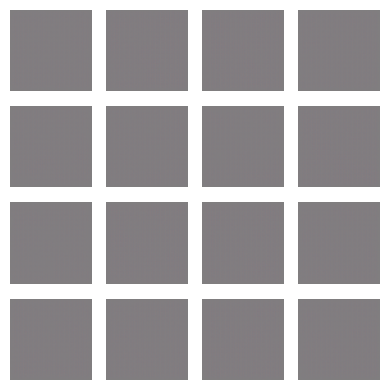

Time for epoch 2 is 1044.5148866176605 sec


In [ ]:
traning(dataset)

Nesse momento, realizamos o treinamento da GAN usando um loop mais detalhado para controlar as perdas do gerador e do discriminador em cada época.

Esse loop mais detalhado permite calcular as perdas médias do gerador e do discriminador em cada época, o que pode ser útil para acompanhar o progresso do treinamento e detectar possíveis problemas (por exemplo, se as perdas estão convergindo ou divergindo).

No final do treinamento, as listas conterão as perdas médias do gerador e do discriminador em cada época, respectivamente.

Essas informações podem ser usadas para analisar a qualidade do treinamento da GAN.

**Em virtude da impossibilidade de concluir o treinamento a tempo do envio do projeto. A sequencia do código não pode ser testada.**

In [ ]:
# Armazenando as perdas
gen_losses = []
disc_losses = []
for epoch in range(1,n_epochs + 1):
    for batch in dataset:
        epoch_gen_loss = 0.0
        epoch_disc_loss = 0.0
        n_batches = 0
        fake_images = generator(noise, training=True)
        real_preds = discriminator(batch, training=True)
        fake_preds = discriminator(fake_images, training=True)
        disc_loss = discriminator_loss(real_preds, fake_preds)
        epoch_disc_loss += disc_loss
        fake_images = generator(noise, training=True)
        fake_preds = discriminator(fake_images, training=True)
        gen_loss = generator_loss(fake_preds)
        epoch_gen_loss += gen_loss
        n_batches += 1
    # Computando média de perdas por época
    epoch_gen_loss /= n_batches
    epoch_disc_loss /= n_batches
    gen_losses.append(epoch_gen_loss)
    disc_losses.append(epoch_disc_loss)

# Analisando resultados

Plotando as curvas de perda (loss) do gerador e do discriminador ao longo das épocas de treinamento da Rede Generativa Adversarial (GAN).

In [ ]:
epochs = list(range(1, n_epochs + 1))
plt.figure(figsize=(9, 5))
plt.plot(epochs, gen_losses, label='Generator Loss', color='blue')
plt.plot(epochs, disc_losses, label='Discriminator Loss', color='orange')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Generator and Discriminator Losses', fontsize=14)
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.legend()
ax = plt.gca()
ax.set_facecolor('lightgray')
plt.show()

Esse gráfico permite visualizar como as perdas do gerador e do discriminador evoluíram durante o treinamento da GAN.

Uma GAN bem treinada terá a perda do gerador diminuindo gradualmente e a perda do discriminador se estabilizando em um valor mais alto (ou seja, não conseguindo distinguir com facilidade entre imagens reais e falsas).

No entanto, é importante observar que o comportamento das curvas de perda pode variar dependendo da arquitetura da GAN, da função de perda e dos hiperparâmetros utilizados.

O gráfico é uma ferramenta útil para avaliar o progresso do treinamento e fazer ajustes se necessário para melhorar o desempenho da GAN.